# Import data into dataframe

In [1]:
#import the required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from numpy import log
import warnings 
warnings.filterwarnings("ignore")

#create list of product_id, quantity0 to quantity117
mylist=["product_id"]
for i in range(118):
    mylist.append("quantity"+str(i))
    
#Getting product data from product_distribution_training_set
raw_df = pd.read_csv('product_distribution_training_set.txt',sep="\t",names=mylist)

#take transpose of the raw_df
dataset=raw_df.transpose()
dataset.columns=dataset.iloc[0]
dataset = dataset[1:]

#Calculating the sum of sales of Products for each day (call it as overall dataset)
dataset_overall = dataset.sum(axis=1,skipna = True) 

#change the index of dataframe to dates
dates = pd.date_range('2021-01-01',periods=118,freq='D')
dataset_overall.index=dates
dataset_overall.index.name = 'days'

#Calculating the sum of sales of Products for each day (call it as overall dataset)
dataset_overall1 = dataset.sum(axis=1,skipna = True) 

#change the index of dataframe to dates
dates = pd.date_range('2021-01-01',periods=118,freq='D')
dataset_overall1.index=dates
dataset_overall1.index.name = 'days'

dataset.index = dates
dataset.index.name = 'days'

# Augmented Dickey-Fuller Test : to check the stationarity

In [2]:
X = dataset_overall1.values
res = adfuller(X)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))
#print("p-value:", adfuller(dataset_overall.dropna())[1])


# critical values - context of population distribution and probability
# Standard alpha values are used when calculating critical values :
# 1% (alpha=0.01)
# 5% (alpha=0.05)
# 10% (alpha=0.10)
#ADF statistic value greater that critical value at 1%, fail to reject null hypothesis
#p-value is greater than the significance level of 0.05, so we fail to reject the null hypothesis. The series is not stationary and requires differencing.


ADF Statistic: -0.983734
p-value: 0.759151
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


In [3]:
dataset_diff = dataset_overall1.diff(periods = 1)
dataset_diff = dataset_diff.dropna()
X = dataset_diff.values
Y = X[~np.isnan(X)]
#print(Y)
res = adfuller(Y)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))
    
#again p>0.05 not stationary

ADF Statistic: -1.547321
p-value: 0.509986
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


In [4]:
#log transform the difference dataset again to make the distribution of values more linear and better meet the expectations of this statistical test.
dataset_diff = dataset_overall1.diff(periods = 1)
dataset_diff = dataset_diff.dropna()
X = dataset_diff.values
X = log(X)
Y = X[~np.isnan(X)]
#print(Y)
res = adfuller(Y)
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -7.321095
p-value: 0.000000
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596


# Trend and Seasonality plot - check stationarity

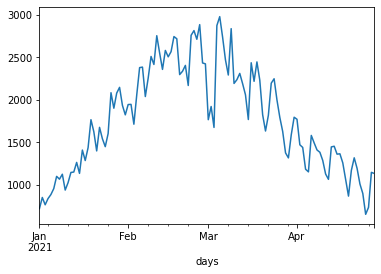

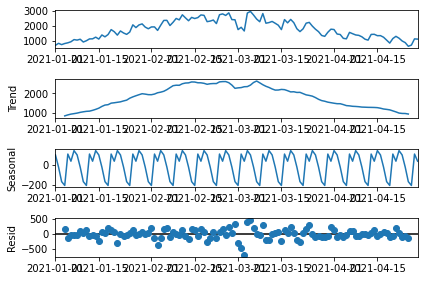

In [5]:
#for overall dataset - seasonality and trend plot
'''
seasonal_decompose 
statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
x : array-like -> dataset_overall dataframe
model : {“additive”, “multiplicative”} Type of seasonal component. here additive because we can see from the overall plot that seasonality
is increasing linearly
'''
result = seasonal_decompose(dataset_overall,  model='additive')
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
dataset_overall.plot()
pyplot.show()
result.plot()
pyplot.show()

# Make Data Stationary : Differencing

<AxesSubplot:xlabel='days'>

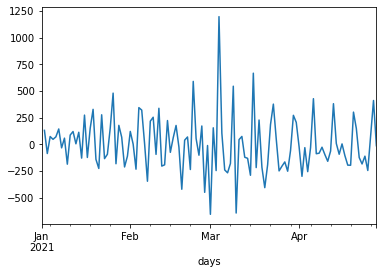

In [6]:
#For ARIMA you need to make the series stationary
#in case of auto Arima, it takes care of diffrencing for stationarity
'''
DataFrame.diff(periods=1, axis=0)
periods int, default 1
Periods to shift for calculating difference, accepts negative values.
axis{0 or ‘index’, 1 or ‘columns’}, default 0
'''
# dataset_diff = dataset_overall.diff(periods = 1)
# dataset_diff.plot()

#OR

dataset_diff1 = dataset_overall - dataset_overall.shift(1)
dataset_diff1.plot()

# ACF and PACF plots

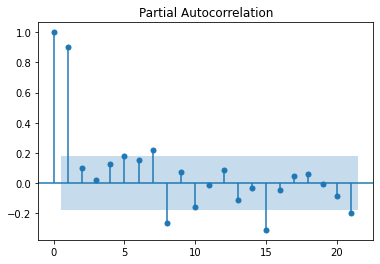

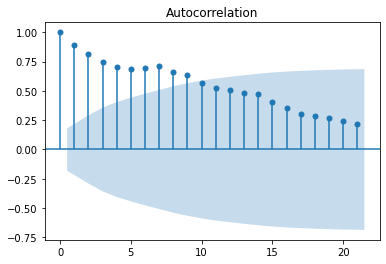

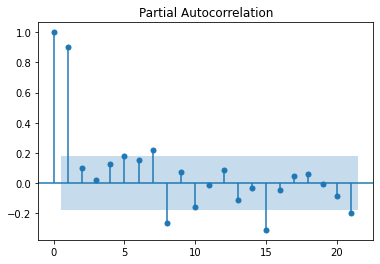

In [7]:
#in case of ARIMA, it is required to find out p and q values from below plots.
#Auto ARIMA will do this for you on it's own
'''
statsmodels.graphics.tsaplots.plot_acf(x, ax=None, lags=None, *, alpha=0.05, use_vlines=True, adjusted=False, fft=False, missing='none', title='Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)
'''
plot_acf(dataset_overall)
'''
statsmodels.graphics.tsaplots.plot_pacf(x, ax=None, lags=None, alpha=0.05, method='ywadjusted', use_vlines=True, title='Partial Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)
'''
plot_pacf(dataset_overall)

# Split the data : First Split (80 - train and 38 - test)

In [8]:
#splitting the data into train(80) and test(38) for determining the model and finding the RMSE, MAPE 
train = dataset_overall[0:80]
test = dataset_overall[80:]


#auto_arima for finding the best model for given data
'''
pmdarima.arima.auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
parameter
y = array like or iterable, train
start and max values for p,d,q,P,D,Q
seasonal = True if seasonality present in data
'''

model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, start_Q=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=1033.715, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1042.337, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1029.560, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1015.616, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1043.678, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=1017.606, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=1017.601, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1029.396, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1015.486, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1017.482, Time=0.43 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=1017.481, Time=0.48 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=1027.796, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=1

# Prediction and accuracy calculation - plot,RMSE and MAPE

RMSE=441.74 
MAPE = 34.20 


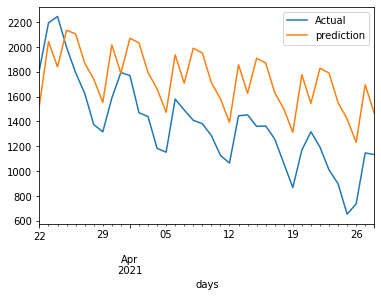

In [9]:
#future prediction for the days same as len of test set
future_forecast = model.predict(n_periods = 38)
#convert future_forecast and test series into dataframe
future_forecast = pd.DataFrame(future_forecast,index = test.index, columns = ['prediction'])
test = pd.DataFrame(test,columns = ['Actual'])

#concat both the dataframe and plot to see the accuracy
pd.concat([test,future_forecast],axis=1).plot()

#find the RMSE and MAPE values 
error = np.sqrt(mean_squared_error(test,future_forecast))
print('RMSE=%.2f '%(error))

# calculate MAPE
# parameters :
#     y_true - test data
#     y_pred - prediction data
# return mean absolute percentage error for the model

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er = mean_absolute_percentage_error(test,future_forecast)
print('MAPE = %.2f '%(er))

# Split the data : First Split (90 - train and 28 - test)

In [10]:
#splitting the data into train(90) and test(28) for determining the model and finding the RMSE, MAPE 
train = dataset_overall[0:90]
test = dataset_overall[90:]

#auto_arima for finding the best model for given data
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, start_Q=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=1172.534, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1183.716, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1169.675, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1153.875, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1183.993, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=1155.313, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1169.049, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1154.605, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=1150.470, Time=0.82 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=1152.062, Time=0.82 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=1152.096, Time=1.61 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=1159.657, Time=0.46 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=1

# Prediction and accuracy calculation - plot,RMSE and MAPE 

RMSE=259.00 
MAPE = 21.45 


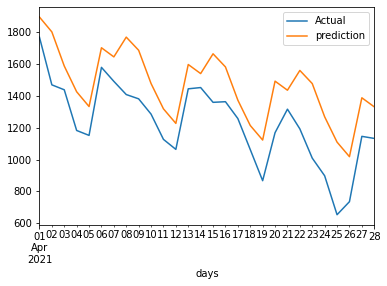

In [11]:
#future prediction for the days same as len of test set
future_forecast = model.predict(n_periods = 28)
#convert future_forecast and test series into dataframe
future_forecast = pd.DataFrame(future_forecast,index = test.index, columns = ['prediction'])
test = pd.DataFrame(test,columns = ['Actual'])

#concat both the dataframe and plot to see the accuracy
pd.concat([test,future_forecast],axis=1).plot()

#find the RMSE and MAPE values 
error = np.sqrt(mean_squared_error(test,future_forecast))
print('RMSE=%.2f '%(error))

er = mean_absolute_percentage_error(test,future_forecast)
print('MAPE = %.2f '%(er))

# Split the data : First Split (110 - train and 8 - test)

In [12]:
#splitting the data into train(110) and test(8) for determining the model and finding the RMSE, MAPE 
train = dataset_overall[0:110]
test = dataset_overall[110:]

#auto_arima for finding the best model for given data
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, start_Q=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=1437.799, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1453.353, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1434.552, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1413.960, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1453.095, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=1414.912, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1433.724, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=1416.884, Time=1.87 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1415.935, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=1409.293, Time=0.79 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=1410.581, Time=0.84 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=1410.676, Time=1.24 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=1421.552, Time=0.46 sec
 ARIMA(1,1,1)(1,1,2)[7]             : 

# Prediction and accuracy calculation - plot,RMSE and MAPE

RMSE=103.51 
MAPE = 9.52 


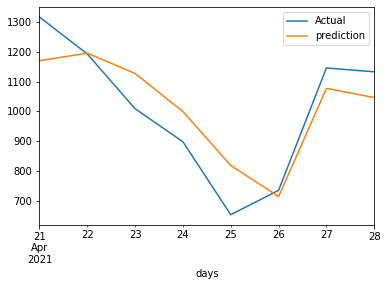

In [13]:
#future prediction for the days same as len of test set
future_forecast = model.predict(n_periods = 8)
#convert future_forecast and test series into dataframe
future_forecast = pd.DataFrame(future_forecast,index = test.index, columns = ['prediction'])
test = pd.DataFrame(test,columns = ['Actual'])

#concat both the dataframe and plot to see the accuracy
pd.concat([test,future_forecast],axis=1).plot()

#find the RMSE and MAPE values 
error = np.sqrt(mean_squared_error(test,future_forecast))
print('RMSE=%.2f '%(error))

er = mean_absolute_percentage_error(test,future_forecast)
print('MAPE = %.2f '%(er))

In [16]:
#Calculating the sum of sales of Products for each day (call it as overall dataset)
dataset_overall = dataset.sum(axis=1,skipna = True) 

#change the index of dataframe to dates
dates = pd.date_range('2021-01-01',periods=118,freq='D')
dataset_overall.index=dates
dataset_overall.index.name = 'days'

# Find Best model for overall data

In [17]:
#auto_arima for finding the best model for overall data
model = auto_arima(dataset_overall, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, start_Q=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=1543.644, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1560.973, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1540.185, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1517.744, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1560.523, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=1519.050, Time=1.38 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1539.224, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1520.292, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=1512.181, Time=0.77 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=1513.709, Time=0.74 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=1513.750, Time=1.61 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=1525.729, Time=0.44 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=i

# apply SARIMA model on train data and check the acuuracy on test data

In [18]:
#same model ARIMA(1,1,1)(0,1,1)[7] each time

#split the data
train_data = dataset_overall[0:105]
test_data = dataset_overall[105:]

#pass the model value to SARIMAX and fit the model and check the summary
'''
statsmodels.tsa.statespace.sarimax.SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
endog - array like (train_data) 
order - (p,d,q) order (1,1,1) got from auto_arima
seasonal_order - (P,D,Q,m) (0,1,1,7) from auto arima
'''
model = SARIMAX(train_data, order = (1,1,1), seasonal_order =(0,1,1,7)) 
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -668.529
Date:                           Sat, 10 Apr 2021   AIC                           1345.057
Time:                                   07:49:58   BIC                           1355.356
Sample:                               01-01-2021   HQIC                          1349.222
                                    - 04-15-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4856      0.201      2.411      0.016       0.091       0.880
ma.L1         -0.7980      0.137     -5.844      0.000      -1.066      -0.530
ma.S.L7       -0.7143      0.092     -7.803      0.000      -0.894      -0.535
sigma2      5.378e+04   6444.338      8.345      0.000    4.11e+04    6.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.08
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.23
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Future Prediction

In [19]:
#predict the future values of 10 days 
future_forecast = result.predict(start='2021-04-16',end='2021-04-28')

# RMSE and MAPE

In [20]:
#find the RMSE and MAPE values 
error = np.sqrt(mean_squared_error(test_data,future_forecast))
print('RMSE=%.2f '%(error))

er = mean_absolute_percentage_error(test_data,future_forecast)
print('MAPE = %.2f '%(er))

RMSE=88.98 
MAPE = 7.60 


# Plot original data and predicted data

In [21]:
#convert future_forecast and test_data series into dataframe 
test_data = pd.DataFrame(test_data,columns = ['original'])
future_forecast = pd.DataFrame(future_forecast)
future_forecast.index.name = 'days'

<AxesSubplot:xlabel='days'>

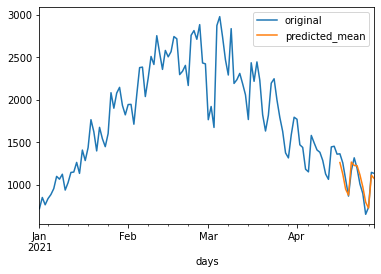

In [22]:
dataset_overall1 = pd.DataFrame(dataset_overall,columns=['original'])
#concat both and plot the graph
pd.concat([dataset_overall1,future_forecast],axis=1).plot()

# Zoomed view plot

<AxesSubplot:xlabel='days'>

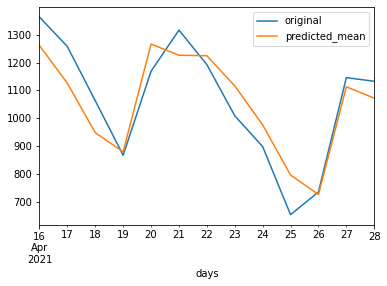

In [23]:
pd.concat([test_data,future_forecast],axis=1).plot()

# Apply the Best model:  ARIMA(1,1,1)(0,1,1)[7] on overall data and on each key product

In [24]:
#total number of key products
total_key_products = len(dataset.columns)
#create empty dataframe to store the final predictions
output = pd.DataFrame()

#use the best model on overall data to predict the 29 days future sales
model = SARIMAX(dataset_overall, order = (1,1,1), seasonal_order =(0,1,1,7)) 
result = model.fit()

prediction = result.predict(start = '2021-04-29', end = '2021-05-27')
#insert the prediction into the empty dataframe
output.insert(0,0,prediction)

#use below for loop to predict the future sale for individual product
for productid in range(total_key_products):
    #take data for product into series productsale
    productsales = dataset.iloc[:,productid]
    #use the model
    model = SARIMAX(productsales, order = (1,1,1), seasonal_order =(0,1,1,7)) 
    result = model.fit()
    #predict the future sale for 29 days
    prediction = result.predict(start = '2021-04-29', end = '2021-05-27')
    #insert the prediction into the output dataframe
    output.insert(productid+1,dataset.columns.values[productid],prediction)



# Make all the negative predictions 0, convert the predictions from float to Int (sales) 

In [25]:
#if prediction sales are less than zero make it zero
output[output<=0] = 0
#convert the predictions from floating point to Int
output = output.round(0).astype(pd.Int64Dtype())
#take transpose of the dataframe for required output format
final_result = output.transpose()

In [26]:
#make index(key product ids) as the first column (output requirement) 
final_result.reset_index(inplace=True)
#rename the first column
final_result = final_result.rename(columns={'index':'key_product_ids'})
#final result in required format
final_result

,key_product_ids,2021-04-29 00:00:00,2021-04-30 00:00:00,2021-05-01 00:00:00,2021-05-02 00:00:00,2021-05-03 00:00:00,2021-05-04 00:00:00,2021-05-05 00:00:00,2021-05-06 00:00:00,2021-05-07 00:00:00,...,2021-05-18 00:00:00,2021-05-19 00:00:00,2021-05-20 00:00:00,2021-05-21 00:00:00,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00
0,0,1077,959,829,624,571,947,952,910,798,...,636,642,600,488,361,158,105,481,487,445
1,1,86,74,71,54,40,88,71,86,72,...,84,68,83,69,66,49,35,83,66,81
2,4,22,13,17,28,9,19,0,13,3,...,0,0,0,0,0,0,0,0,0,0
3,5,11,13,17,7,14,14,7,6,8,...,3,0,0,0,1,0,0,0,0,0
4,6,9,5,6,0,4,7,0,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,865,4,4,4,4,4,5,5,5,4,...,5,5,5,5,5,5,5,5,5,5
97,922,5,6,3,4,3,4,5,5,6,...,5,5,5,6,3,4,3,5,5,5
98,949,2,0,0,0,1,1,1,2,0,...,1,1,2,0,0,0,1,1,1,2
99,962,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


# export data into a text file

In [27]:
#export the data into .txt file 
'''
DataFrame.to_csv(path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None, decimal='.', errors='strict', storage_options=None)
'''
#specify mode='x' if you don't want to overwrite the file
#specify the path where you want to save the output file
#final_result.to_csv(r'C:\Users\Priyanka\Desktop\Python\Data Mining Project\output.txt', header=None, index=None, sep='\t')
#without file path, it will save at current location
final_result.to_csv(r'output.txt', header=None, index=None, sep='\t') 